<a href="https://colab.research.google.com/github/AMIRMOHAMMAD-OSS/Bioinformatics/blob/main/Phaseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phaseek a Liquid-Liquid Phase Separation (LLPS) Protein Scorer!

This tool allows you to analyze protein sequences for their propensity to undergo phase separation:

Input Options:
Upload a single protein sequence directly into the designated box.
Alternatively, load a FASTA file containing multiple protein sequences.

To maintain efficiency, we advise against loading more than 100 sequences at once

Specify the sequence ID or directory for your analysis.

By setting the 'End_Sequence'  parameter,you can focus the scoring on sequences up to the specified endpoint.

In [1]:
#@title Installation
%%capture
!pip install biopython streamlit py3Dmol requests biotite stmol command_runner plotly "kaleido==0.1.*" transformers ipympl
!apt-get update -qq && apt-get install -y ncbi-blast+


In [2]:
#@title Setup
%%time
import os, time ,io
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from command_runner import command_runner
import torch
import numpy as np
from google.colab import output


try:
  if not os.path.isfile("/content/Phaseek/Functions/Configue.py"):
      os.makedirs('/content/Phaseek/', exist_ok=True)
      !git clone https://github.com/AMIRMOHAMMAD-OSS/classi /content/Phaseek/
      %cd /content/Phaseek/Functions
      output.clear()
      print("Everything looks ok! ✨🍰✨\n\n\n\n")

  else:
      %cd /content/Phaseek/Functions
      output.clear()
      print("Phaseek already installed, ready to run!\n\n")
except:
  print("Sonthing has gone wrong!")


Everything looks ok! ✨🍰✨




CPU times: user 1.68 s, sys: 330 ms, total: 2.01 s
Wall time: 9.1 s


In [5]:
#@title Device Availability

if torch.cuda.is_available():
  print("Cuda is available 🎉\n")
  print("The allocated device is : "+torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  print("Cuda is not available 😔\n")
  print("The allocated device is : cpu")
  device = torch.device("cpu")


Cuda is available 🎉

The allocated device is : Tesla T4


In [9]:
#@title Loading sequence , then hit `Runtime` -> `Run all`
#@markdown - Load the `Sequence` of your protein Specify the path of `FASTA format file` of your sequences. :
Sequence = "MSYPGYPPPPGGYPPAAPGGGPWGGAAYPPPPSMPPIGLDNVATYAGQFNQDYLSGMAANMSGTFGGANMPNLYPGAPGAGYPPVPPGGFGQPPSAQQPVPPYGMYPPPGGNPPSRMPSYPPYPGAPVPGQPMPPPGQQPPGAYPGQPPVTYPGQPPVPLPGQQQPVPSYPGYPGSGTVTPAVPPTQFGSRGTITDAPGFDPLRDAEVLRKAMKGFGTDEQAIIDCLGSRSNKQRQQILLSFKTAYGKDLIKDLKSELSGNFEKTILALMKTPVLFDIYEIKEAIKGVGTDEACLIEILASRSNEHIRELNRAYKAEFKKTLEEAIRSDTSGHFQRLLISLSQGNRDESTNVDMSLAQRDAQELYAAGENRLGTDESKFNAVLCSRSRAHLVAVFNEYQRMTGRDIEKSICREMSGDLEEGMLAVVKCLKNTPAFFAERLNKAMRGAGTKDRTLIHIMVSRSETDLLDIRSEYKRMYGKSLYHDISGDTSGDYRKILLKICGGND" #@param {type:"string"}
ID = "Anexxin_mutants" #@param {type:"string"}
Directory = "ANXX_R456H" #@param {type:"string"}
#@markdown  - Use `End_sequence` to focus the scoring on sequences up to the specified endpoint
End_sequence = 287 #@param {type:"slider" , min : 0 , max: 1000 , step : 1}
def edit_seq(seq):
  for i in seq:
    if i not in "ACDEFGHIKLMNPQRSTVWY":
      seq = seq.replace(i,"")
  return seq
Sequence = edit_seq(Sequence)

if Directory == None:
  Directory = "Suggested_Directory{i}".format(i = np.random.randint(0,10000))
if ID == None:
  ID = "Suggested_ID{i}".format(i = np.random.randint(0,10000))


command = "python runner.py --sequence {Sequence} --end_sequence {End_sequence} --plot True --directory {Directory} --id {ID}".format(Sequence = Sequence,End_sequence=End_sequence,Directory = Directory,ID = ID)
exit_code, output = command_runner(command, shell=True, live_output=True)


w = False
if ".fasta" not in  Sequence:
  w = True
  score = float(output.split(" ")[1][:-1])



Score: 0.8863313192012803


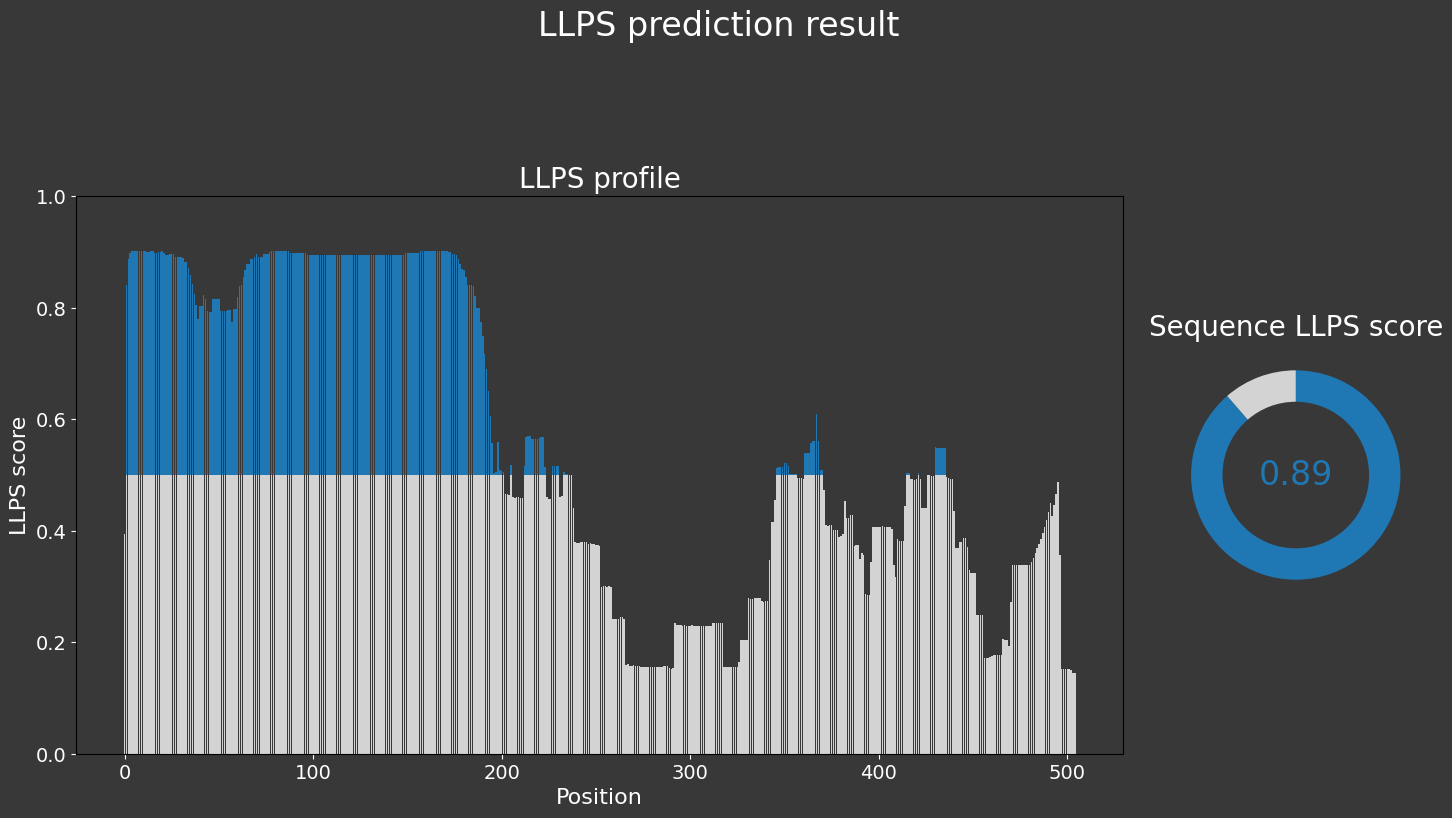

In [10]:
#@title plot
import matplotlib.pyplot as plt
import pandas as pd

if w:
    files = "/content/Phaseek/Results/{dir}/{id}/scores.csv".format(dir = Directory,id = ID)
    scores = pd.read_csv(files)["scores"].values.tolist()
    Sequence = "".join(pd.read_csv(files)["seq"].values.tolist())
    threshold = 0.5
    below_threshold = [min(k, threshold) for k in scores]
    above_threshold = [max(0, k - threshold) for k in scores]
    x_indices = list(range(len(scores)))

    metric_value = score
    main_color = "#1f77b4"
    background_color = "#383838"
    remaining_color = "#d3d3d3"

    fig, axes = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]}, facecolor=background_color)

    fig.suptitle("LLPS prediction result", fontsize=24, color="white", y=1.05)
    ax1 = axes[0]
    ax1.bar(x_indices, below_threshold, color=remaining_color, label="Below Threshold")
    ax1.bar(x_indices, above_threshold, bottom=below_threshold, color=main_color, label="Above Threshold")
    ax1.set_ylim(0, 1)

    ax1.set_title("LLPS profile", color="white", fontsize=20)
    ax1.set_xlabel("Position", color="white", fontsize=16)
    ax1.set_ylabel("LLPS score", color="white", fontsize=16)
    ax1.tick_params(colors="white", labelsize=14)
    ax1.set_facecolor(background_color)
    ax2 = axes[1]
    ax2.pie(
        [metric_value, 1 - metric_value],
        colors=[main_color, remaining_color],
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.3})

    ax2.text(0, 0, f'{metric_value:.2f}', ha='center', va='center', fontsize=24, color=main_color)
    ax2.set_aspect('equal')
    ax2.set_facecolor(background_color)
    ax2.axis('off')
    ax2.set_title("Sequence LLPS score", fontsize=20, color="white")

    plt.tight_layout(pad=3.0)
    plt.savefig("/content/Phaseek/Results/{dir}/{id}/LLPS_profile{iD}.svg".format(dir = Directory,id = ID,iD = ID), format='svg', bbox_inches='tight', facecolor=background_color)
    plt.show()


In [ ]:
#@title Downloading the results

import shutil
import os
from google.colab import files

# Define the directory to be zipped
directory_to_zip = '/content/Phaseek/Results'

# Output zip file name
zip_file_name = '/content/Phaseek_analysis_results.zip'

# Create the ZIP file
shutil.make_archive(base_name=zip_file_name.replace('.zip', ''),
                    format='zip',
                    root_dir=directory_to_zip)

# Download the ZIP file
files.download(zip_file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>